In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor, AdamW, get_linear_schedule_with_warmup
import time
import timm
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot
from sklearn.preprocessing import label_binarize

2024-06-02 05:44:42.599674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 05:44:42.599784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 05:44:42.712342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-y8xw11ch
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-y8xw11ch
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4973 sha256=fe0efcc5aede1f384e355ea01ec944b24c704cc4a8de57b3eef92fca8f576429
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0fu5y6q/wheels/97/11/17/d09e895f9883bd50923ce86b249a31790356a1b88b280983d8
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [3]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [4]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


In [5]:
# Define custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [6]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

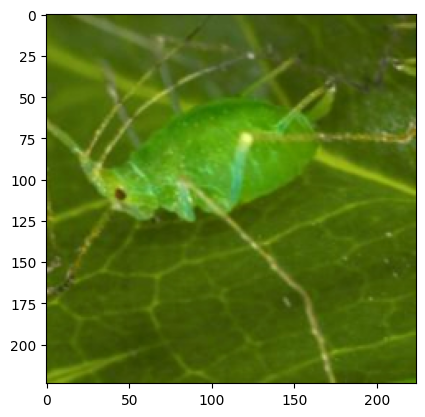

In [7]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [8]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### ViT

In [9]:
# Load ViT configuration and create a model from scratch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = ViTConfig(num_labels=17, hidden_size=768, num_attention_heads=12, num_hidden_layers=12)
model = ViTForImageClassification(config).to(device)

In [10]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
epochs = 100
criterion = nn.CrossEntropyLoss()
num_training_steps = epochs * len(train_loader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [11]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                                       Output Shape              Param #
ViTForImageClassification                                    [32, 17]                  --
├─ViTModel: 1-1                                              [32, 197, 768]            --
│    └─ViTEmbeddings: 2-1                                    [32, 197, 768]            152,064
│    │    └─ViTPatchEmbeddings: 3-1                          [32, 196, 768]            590,592
│    │    └─Dropout: 3-2                                     [32, 197, 768]            --
│    └─ViTEncoder: 2-2                                       [32, 197, 768]            --
│    │    └─ModuleList: 3-3                                  --                        85,054,464
│    └─LayerNorm: 2-3                                        [32, 197, 768]            1,536
├─Linear: 1-2                                                [32, 17]                  13,073
Total params: 85,811,729
Trainable params: 85,811,729
Non-trainable pa

In [12]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [13]:
# dummy input untuk memvisualisasikan arsitektur
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)
y = output.logits 
dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
dot.format = 'png'
dot.render('model_architecture_torchviz')
torch.onnx.export(model, dummy_input, "model.onnx", verbose=False)


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


In [14]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    logits = pred.logits  # Ekstrak logits dari output
    logits = F.softmax(logits, dim=1)
    acc = (true == logits.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [15]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    logits = pred.logits  # Ekstrak logits dari output
    logits = F.softmax(logits, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    logits = logits.cpu().numpy()
    return f1_score(true, logits, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [16]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    train_loss = checkpoint['train_loss']
    train_accuracy = checkpoint['train_accuracy']
    train_f1_score = checkpoint['train_f1_score']
    val_loss = checkpoint['val_loss']
    val_accuracy = checkpoint['val_accuracy']
    val_f1_score = checkpoint['val_f1_score']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    train_loss = []
    train_accuracy = []
    train_f1_score = []
    val_loss = []
    val_accuracy = []
    val_f1_score = []
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [17]:
# Initialize training and validation statistics
epochs = 100
patience = 7

In [18]:
# Training loop
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds.logits, labels)  # Ekstrak logits dari output
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds.logits, labels)  # Ekstrak logits dari output

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        checkpoint_best = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint_best, 'checkpoint_best.pth')
        torch.save(model.state_dict(), 'best_vit_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'train_f1_score': train_f1_score,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'val_f1_score': val_f1_score
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} due to early stopping')
            break

    lr_scheduler.step()

Epoch 1/100: 100%|██████████| 154/154 [02:31<00:00,  1.02batch/s, Training Loss=2.72, Training Accuracy=12.2, Training F1 Score=0.0621]


Epoch 1/100, Training Loss: 2.7239, Training Accuracy: 12.18%, Training F1 Score: 0.06
Validation Loss: 2.5504, Validation Accuracy: 16.59%, Validation F1 Score: 0.12, Epoch Duration: 173.79 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [02:16<00:00,  1.12batch/s, Training Loss=2.38, Training Accuracy=22.6, Training F1 Score=0.175]


Epoch 2/100, Training Loss: 2.3843, Training Accuracy: 22.59%, Training F1 Score: 0.18
Validation Loss: 2.2996, Validation Accuracy: 21.98%, Validation F1 Score: 0.19, Epoch Duration: 155.76 seconds
Best model saved


Epoch 3/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=2.19, Training Accuracy=28.4, Training F1 Score=0.25]


Epoch 3/100, Training Loss: 2.1933, Training Accuracy: 28.36%, Training F1 Score: 0.25
Validation Loss: 2.1599, Validation Accuracy: 30.94%, Validation F1 Score: 0.28, Epoch Duration: 158.26 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s, Training Loss=2.01, Training Accuracy=34.6, Training F1 Score=0.313]


Epoch 4/100, Training Loss: 2.0147, Training Accuracy: 34.59%, Training F1 Score: 0.31
Validation Loss: 2.0316, Validation Accuracy: 33.87%, Validation F1 Score: 0.30, Epoch Duration: 161.67 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [02:31<00:00,  1.02batch/s, Training Loss=1.88, Training Accuracy=38.6, Training F1 Score=0.358]


Epoch 5/100, Training Loss: 1.8812, Training Accuracy: 38.59%, Training F1 Score: 0.36
Validation Loss: 1.7903, Validation Accuracy: 39.94%, Validation F1 Score: 0.36, Epoch Duration: 173.71 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=1.66, Training Accuracy=46.3, Training F1 Score=0.442]


Epoch 6/100, Training Loss: 1.6620, Training Accuracy: 46.30%, Training F1 Score: 0.44
Validation Loss: 1.7179, Validation Accuracy: 44.96%, Validation F1 Score: 0.43, Epoch Duration: 163.73 seconds
Best model saved


Epoch 7/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=1.51, Training Accuracy=50.7, Training F1 Score=0.487]


Epoch 7/100, Training Loss: 1.5094, Training Accuracy: 50.74%, Training F1 Score: 0.49
Validation Loss: 1.5812, Validation Accuracy: 49.04%, Validation F1 Score: 0.48, Epoch Duration: 157.46 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [02:19<00:00,  1.11batch/s, Training Loss=1.35, Training Accuracy=55.7, Training F1 Score=0.547]


Epoch 8/100, Training Loss: 1.3454, Training Accuracy: 55.69%, Training F1 Score: 0.55
Validation Loss: 1.2964, Validation Accuracy: 58.31%, Validation F1 Score: 0.57, Epoch Duration: 158.00 seconds
Best model saved


Epoch 9/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=1.15, Training Accuracy=62.5, Training F1 Score=0.613]


Epoch 9/100, Training Loss: 1.1514, Training Accuracy: 62.48%, Training F1 Score: 0.61
Validation Loss: 1.1321, Validation Accuracy: 63.32%, Validation F1 Score: 0.62, Epoch Duration: 156.47 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=1, Training Accuracy=67.1, Training F1 Score=0.661]


Epoch 10/100, Training Loss: 1.0003, Training Accuracy: 67.12%, Training F1 Score: 0.66
Validation Loss: 1.0765, Validation Accuracy: 64.17%, Validation F1 Score: 0.64, Epoch Duration: 156.83 seconds
Model saved at epoch 10
Best model saved


Epoch 11/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.874, Training Accuracy=71.2, Training F1 Score=0.703]


Epoch 11/100, Training Loss: 0.8739, Training Accuracy: 71.19%, Training F1 Score: 0.70
Validation Loss: 0.8811, Validation Accuracy: 72.69%, Validation F1 Score: 0.72, Epoch Duration: 155.73 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.753, Training Accuracy=76.1, Training F1 Score=0.757]


Epoch 12/100, Training Loss: 0.7534, Training Accuracy: 76.06%, Training F1 Score: 0.76
Validation Loss: 0.9133, Validation Accuracy: 70.55%, Validation F1 Score: 0.70, Epoch Duration: 158.79 seconds


Epoch 13/100: 100%|██████████| 154/154 [02:25<00:00,  1.06batch/s, Training Loss=0.692, Training Accuracy=77.9, Training F1 Score=0.774]


Epoch 13/100, Training Loss: 0.6923, Training Accuracy: 77.90%, Training F1 Score: 0.77
Validation Loss: 0.7121, Validation Accuracy: 78.27%, Validation F1 Score: 0.78, Epoch Duration: 166.25 seconds
Best model saved


Epoch 14/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s, Training Loss=0.587, Training Accuracy=81.3, Training F1 Score=0.808]


Epoch 14/100, Training Loss: 0.5867, Training Accuracy: 81.32%, Training F1 Score: 0.81
Validation Loss: 0.7518, Validation Accuracy: 77.50%, Validation F1 Score: 0.77, Epoch Duration: 161.96 seconds


Epoch 15/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.525, Training Accuracy=83.2, Training F1 Score=0.829]


Epoch 15/100, Training Loss: 0.5252, Training Accuracy: 83.16%, Training F1 Score: 0.83
Validation Loss: 0.7051, Validation Accuracy: 77.44%, Validation F1 Score: 0.76, Epoch Duration: 157.96 seconds
Best model saved


Epoch 16/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.487, Training Accuracy=84.2, Training F1 Score=0.84]


Epoch 16/100, Training Loss: 0.4875, Training Accuracy: 84.18%, Training F1 Score: 0.84
Validation Loss: 0.6536, Validation Accuracy: 79.98%, Validation F1 Score: 0.80, Epoch Duration: 157.98 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.448, Training Accuracy=85.3, Training F1 Score=0.85]


Epoch 17/100, Training Loss: 0.4477, Training Accuracy: 85.33%, Training F1 Score: 0.85
Validation Loss: 0.5791, Validation Accuracy: 82.30%, Validation F1 Score: 0.82, Epoch Duration: 157.52 seconds
Best model saved


Epoch 18/100: 100%|██████████| 154/154 [02:19<00:00,  1.11batch/s, Training Loss=0.383, Training Accuracy=87.7, Training F1 Score=0.876]


Epoch 18/100, Training Loss: 0.3830, Training Accuracy: 87.70%, Training F1 Score: 0.88
Validation Loss: 0.5243, Validation Accuracy: 85.15%, Validation F1 Score: 0.85, Epoch Duration: 158.20 seconds
Best model saved


Epoch 19/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.384, Training Accuracy=87.4, Training F1 Score=0.872]


Epoch 19/100, Training Loss: 0.3841, Training Accuracy: 87.42%, Training F1 Score: 0.87
Validation Loss: 0.5539, Validation Accuracy: 83.45%, Validation F1 Score: 0.84, Epoch Duration: 156.60 seconds


Epoch 20/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.339, Training Accuracy=88.9, Training F1 Score=0.888]


Epoch 20/100, Training Loss: 0.3391, Training Accuracy: 88.89%, Training F1 Score: 0.89
Validation Loss: 0.5467, Validation Accuracy: 84.67%, Validation F1 Score: 0.84, Epoch Duration: 156.57 seconds
Model saved at epoch 20


Epoch 21/100: 100%|██████████| 154/154 [02:19<00:00,  1.11batch/s, Training Loss=0.308, Training Accuracy=90.1, Training F1 Score=0.901]


Epoch 21/100, Training Loss: 0.3083, Training Accuracy: 90.06%, Training F1 Score: 0.90
Validation Loss: 0.5364, Validation Accuracy: 84.43%, Validation F1 Score: 0.84, Epoch Duration: 158.25 seconds


Epoch 22/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.274, Training Accuracy=91.3, Training F1 Score=0.912]


Epoch 22/100, Training Loss: 0.2744, Training Accuracy: 91.27%, Training F1 Score: 0.91
Validation Loss: 0.4696, Validation Accuracy: 86.84%, Validation F1 Score: 0.86, Epoch Duration: 156.34 seconds
Best model saved


Epoch 23/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.243, Training Accuracy=91.9, Training F1 Score=0.918]


Epoch 23/100, Training Loss: 0.2427, Training Accuracy: 91.88%, Training F1 Score: 0.92
Validation Loss: 0.4636, Validation Accuracy: 86.76%, Validation F1 Score: 0.87, Epoch Duration: 155.78 seconds
Best model saved


Epoch 24/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.263, Training Accuracy=91.8, Training F1 Score=0.918]


Epoch 24/100, Training Loss: 0.2634, Training Accuracy: 91.84%, Training F1 Score: 0.92
Validation Loss: 0.4770, Validation Accuracy: 86.60%, Validation F1 Score: 0.86, Epoch Duration: 155.90 seconds


Epoch 25/100: 100%|██████████| 154/154 [02:28<00:00,  1.04batch/s, Training Loss=0.243, Training Accuracy=92.3, Training F1 Score=0.924]


Epoch 25/100, Training Loss: 0.2429, Training Accuracy: 92.30%, Training F1 Score: 0.92
Validation Loss: 0.4591, Validation Accuracy: 86.67%, Validation F1 Score: 0.87, Epoch Duration: 167.61 seconds
Best model saved


Epoch 26/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.225, Training Accuracy=92.4, Training F1 Score=0.923]


Epoch 26/100, Training Loss: 0.2252, Training Accuracy: 92.36%, Training F1 Score: 0.92
Validation Loss: 0.4211, Validation Accuracy: 88.44%, Validation F1 Score: 0.89, Epoch Duration: 156.66 seconds
Best model saved


Epoch 27/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.237, Training Accuracy=92.2, Training F1 Score=0.92]


Epoch 27/100, Training Loss: 0.2374, Training Accuracy: 92.18%, Training F1 Score: 0.92
Validation Loss: 0.4963, Validation Accuracy: 86.49%, Validation F1 Score: 0.87, Epoch Duration: 155.68 seconds


Epoch 28/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.211, Training Accuracy=93, Training F1 Score=0.931]


Epoch 28/100, Training Loss: 0.2110, Training Accuracy: 93.03%, Training F1 Score: 0.93
Validation Loss: 0.5207, Validation Accuracy: 85.59%, Validation F1 Score: 0.85, Epoch Duration: 156.32 seconds


Epoch 29/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.2, Training Accuracy=93.6, Training F1 Score=0.935]


Epoch 29/100, Training Loss: 0.2001, Training Accuracy: 93.55%, Training F1 Score: 0.94
Validation Loss: 0.4490, Validation Accuracy: 87.40%, Validation F1 Score: 0.87, Epoch Duration: 155.85 seconds


Epoch 30/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.2, Training Accuracy=93.3, Training F1 Score=0.935]


Epoch 30/100, Training Loss: 0.1997, Training Accuracy: 93.32%, Training F1 Score: 0.94
Validation Loss: 0.4066, Validation Accuracy: 89.80%, Validation F1 Score: 0.90, Epoch Duration: 157.06 seconds
Model saved at epoch 30
Best model saved


Epoch 31/100: 100%|██████████| 154/154 [02:20<00:00,  1.09batch/s, Training Loss=0.145, Training Accuracy=95.4, Training F1 Score=0.953]


Epoch 31/100, Training Loss: 0.1449, Training Accuracy: 95.43%, Training F1 Score: 0.95
Validation Loss: 0.4305, Validation Accuracy: 88.76%, Validation F1 Score: 0.89, Epoch Duration: 159.77 seconds


Epoch 32/100: 100%|██████████| 154/154 [02:21<00:00,  1.09batch/s, Training Loss=0.142, Training Accuracy=95.2, Training F1 Score=0.952]


Epoch 32/100, Training Loss: 0.1420, Training Accuracy: 95.21%, Training F1 Score: 0.95
Validation Loss: 0.4875, Validation Accuracy: 87.85%, Validation F1 Score: 0.87, Epoch Duration: 160.35 seconds


Epoch 33/100: 100%|██████████| 154/154 [02:19<00:00,  1.10batch/s, Training Loss=0.145, Training Accuracy=95.3, Training F1 Score=0.952]


Epoch 33/100, Training Loss: 0.1448, Training Accuracy: 95.25%, Training F1 Score: 0.95
Validation Loss: 0.4169, Validation Accuracy: 89.62%, Validation F1 Score: 0.90, Epoch Duration: 158.22 seconds


Epoch 34/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.17, Training Accuracy=94.4, Training F1 Score=0.944]


Epoch 34/100, Training Loss: 0.1697, Training Accuracy: 94.43%, Training F1 Score: 0.94
Validation Loss: 0.4854, Validation Accuracy: 87.02%, Validation F1 Score: 0.87, Epoch Duration: 156.45 seconds


Epoch 35/100: 100%|██████████| 154/154 [02:17<00:00,  1.12batch/s, Training Loss=0.151, Training Accuracy=95, Training F1 Score=0.95]


Epoch 35/100, Training Loss: 0.1510, Training Accuracy: 94.99%, Training F1 Score: 0.95
Validation Loss: 0.4347, Validation Accuracy: 88.42%, Validation F1 Score: 0.88, Epoch Duration: 156.52 seconds


Epoch 36/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.153, Training Accuracy=95, Training F1 Score=0.951]


Epoch 36/100, Training Loss: 0.1526, Training Accuracy: 95.00%, Training F1 Score: 0.95
Validation Loss: 0.4940, Validation Accuracy: 87.13%, Validation F1 Score: 0.87, Epoch Duration: 157.41 seconds


Epoch 37/100: 100%|██████████| 154/154 [02:18<00:00,  1.11batch/s, Training Loss=0.149, Training Accuracy=95.3, Training F1 Score=0.953]


Epoch 37/100, Training Loss: 0.1486, Training Accuracy: 95.31%, Training F1 Score: 0.95
Validation Loss: 0.4233, Validation Accuracy: 89.54%, Validation F1 Score: 0.90, Epoch Duration: 157.78 seconds
Early stopping triggered
Model saved at epoch 37 due to early stopping


In [19]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

Model saved at the final epoch 37


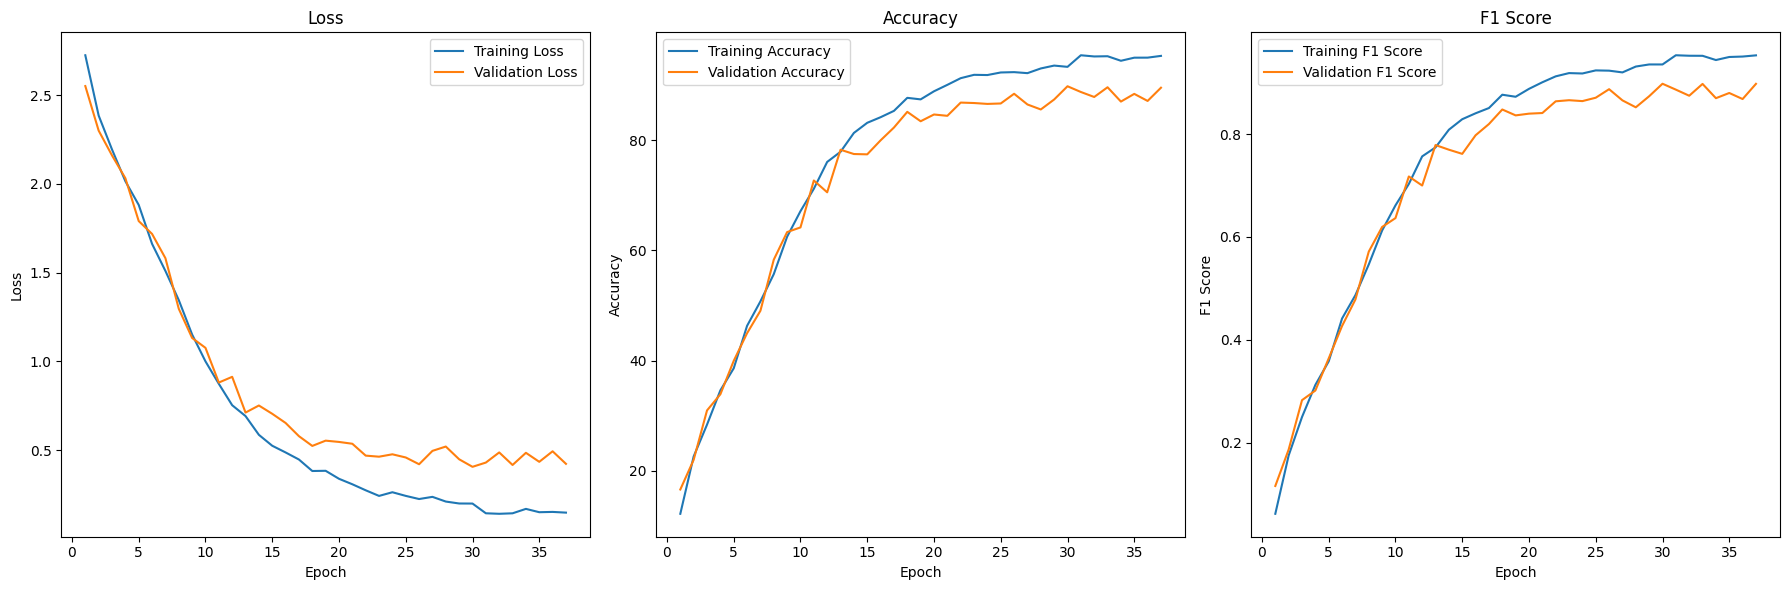

In [20]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

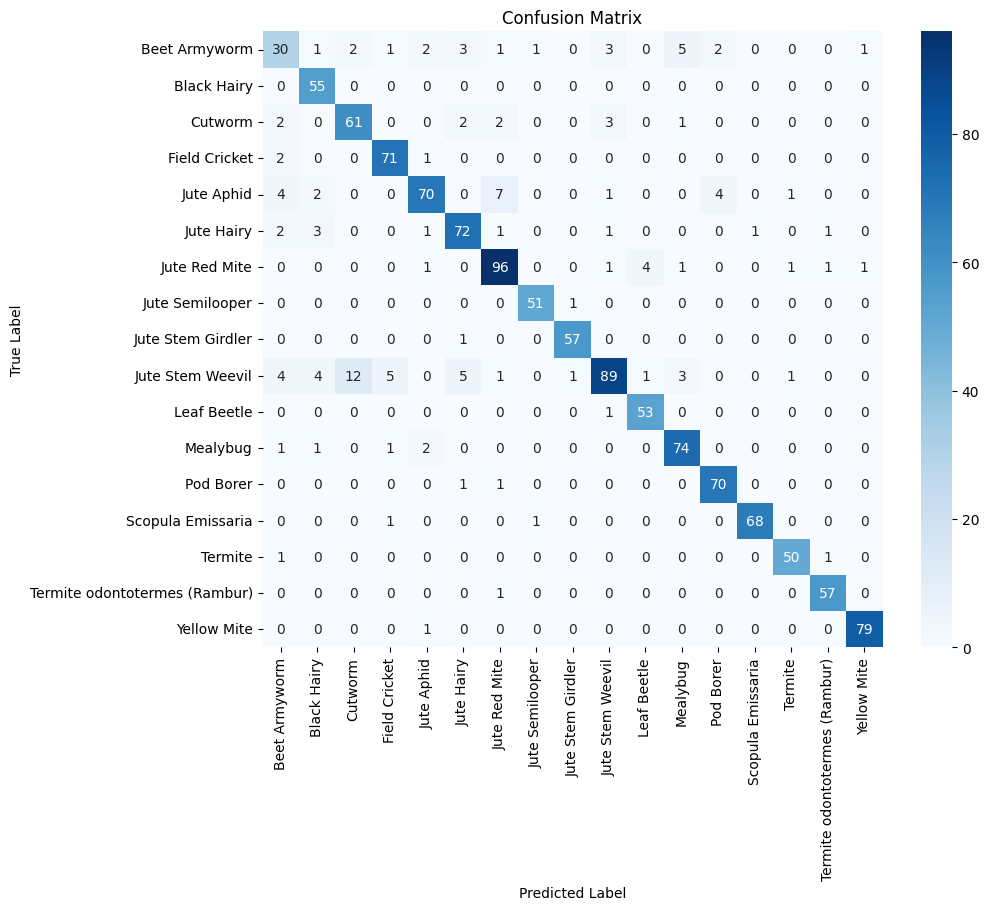

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.65      0.58      0.61        52
                  Black Hairy       0.83      1.00      0.91        55
                      Cutworm       0.81      0.86      0.84        71
                Field Cricket       0.90      0.96      0.93        74
                   Jute Aphid       0.90      0.79      0.84        89
                   Jute Hairy       0.86      0.88      0.87        82
                Jute Red Mite       0.87      0.91      0.89       106
              Jute Semilooper       0.96      0.98      0.97        52
            Jute Stem Girdler       0.97      0.98      0.97        58
             Jute Stem Weevil       0.90      0.71      0.79       126
                  Leaf Beetle       0.91      0.98      0.95        54
                     Mealybug       0.88      0.94      0.91        79
                    Pod Borer       0.92      0.97   

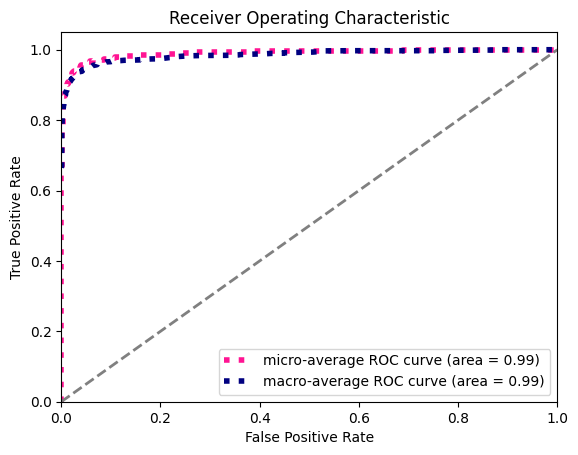

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Fungsi untuk menghitung confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluasi tambahan setelah training selesai
def evaluate_model(model, dataloader, classes):
    model.eval()
    true_labels = []
    pred_labels = []
    logits_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            logits = outputs.logits  # Ekstrak logits dari output
            logits_list.append(logits.cpu().numpy())
            _, preds = torch.max(logits, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    logits_array = np.concatenate(logits_list, axis=0)
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Binarize the labels for ROC calculation
    true_labels_binarized = label_binarize(true_labels, classes=range(len(classes)))

    # Plot confusion matrix
    plot_confusion_matrix(true_labels, pred_labels, classes)

    # Classification report
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=classes, zero_division=1))

    # ROC Curve and AUC for multi-class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], logits_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binarized.ravel(), logits_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(classes)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluasi pada dataset validation setelah training selesai
evaluate_model(model, val_loader, classes=label_encoder.classes_)

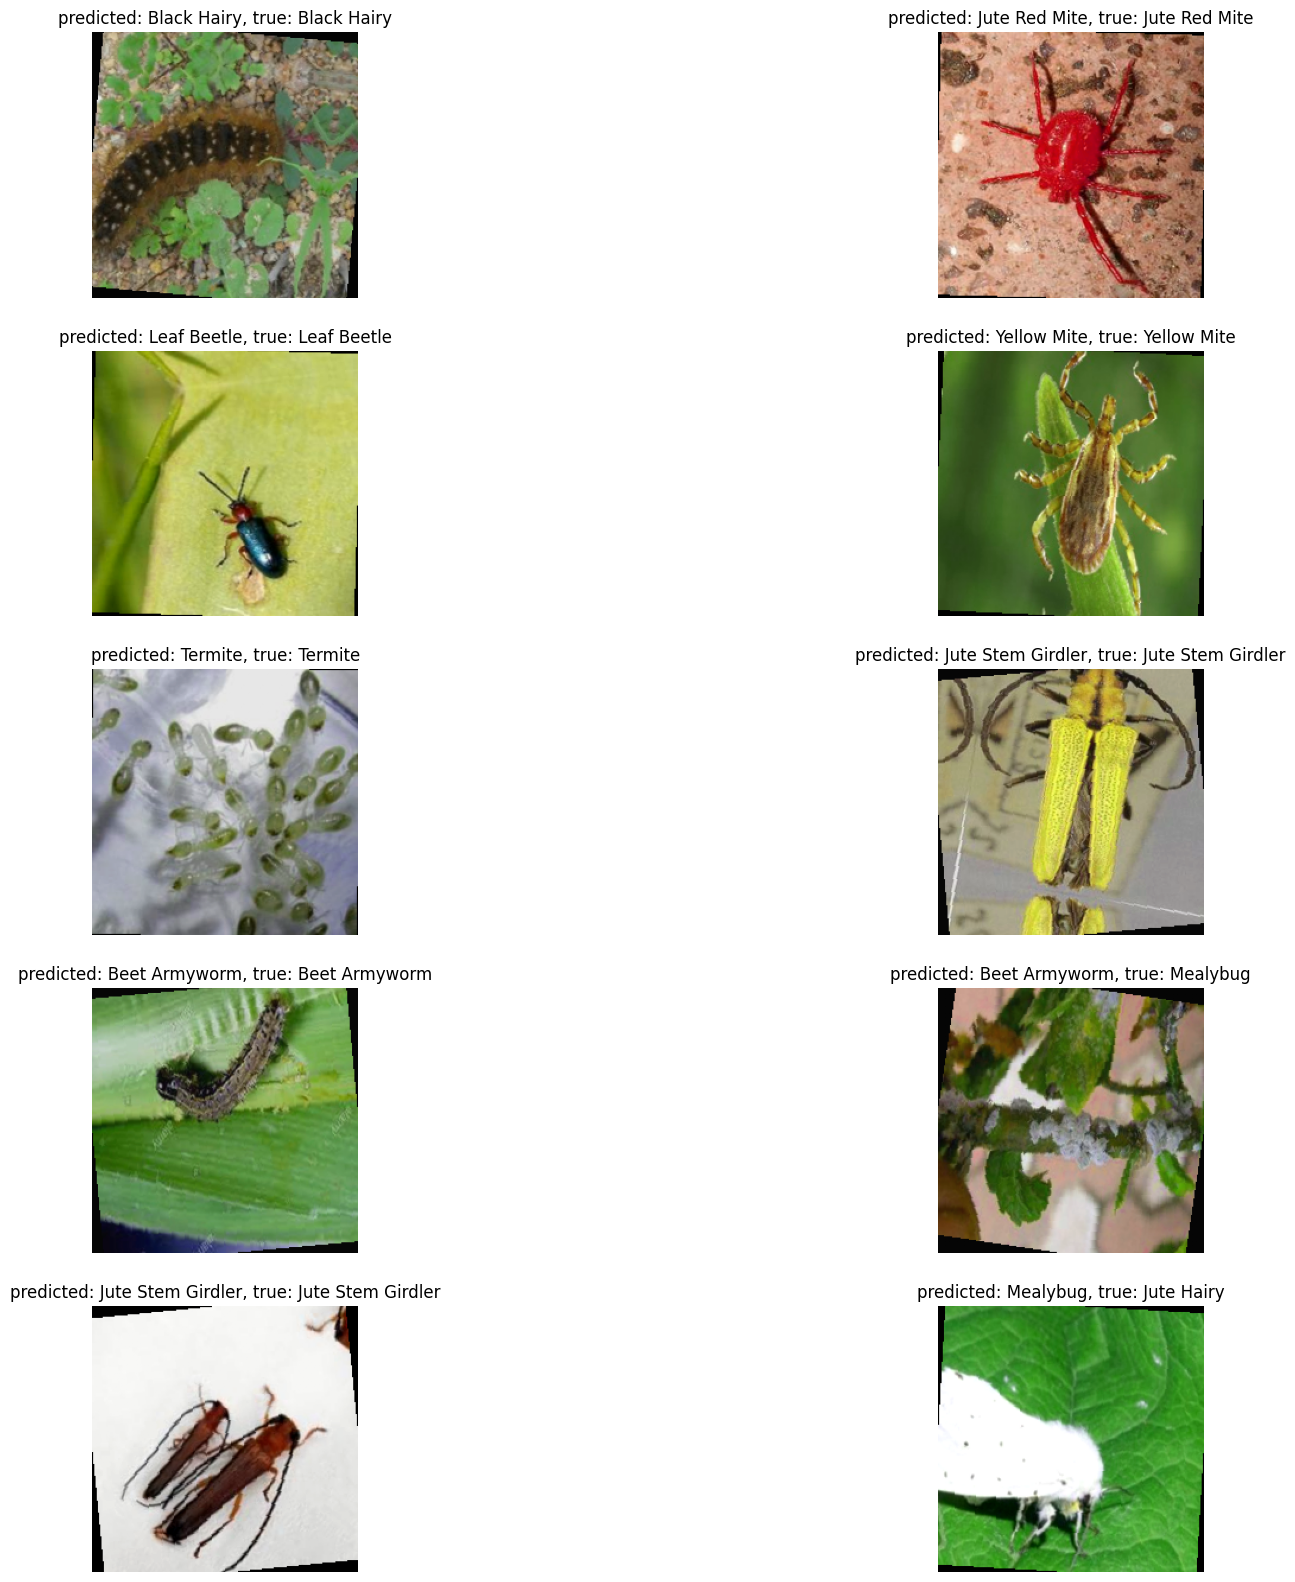

In [22]:
# Visualisasi prediksi pada dataset validation
def visualize_predictions(model, dataloader, classes, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            logits = outputs.logits  # Ekstrak logits dari output
            _, preds = torch.max(logits, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}, true: {classes[labels[j]]}')
                plt.imshow(images.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=True)
                    plt.show()
                    return
        model.train(mode=True)
        plt.show()

# Visualisasi beberapa prediksi pada dataset validation
visualize_predictions(model, val_loader, classes=label_encoder.classes_, num_images=10)

In [23]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

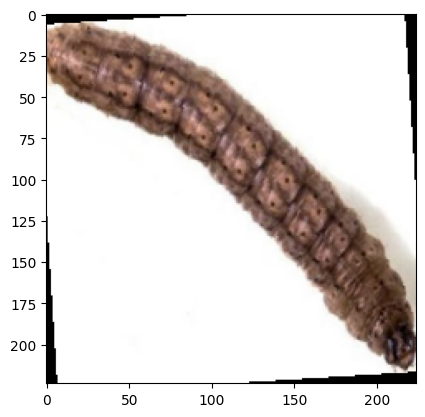

In [24]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()


In [25]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [26]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [27]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [28]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_vit.csv")
sub

,class
id,
0,Cutworm
1,Jute Hairy
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Jute Hairy
1083,Jute Stem Girdler
